<a href="https://colab.research.google.com/github/thamizhselvan07/Paisabazaar-Credit-Score-Classifier/blob/main/Paisabazaar_Credit_Score_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Name  -    Paisabazaar Credit Score Classifier**

##### **Project Type**    - Classification
##### **Contribution**    - Individual

# **Project Summary**

**The objective of this project was to build a robust machine learning classification model capable of predicting an individual’s credit score category—classified as "Poor", "Standard", or "Good"—using demographic, financial, and behavioral features collected by Paisabazaar. Accurate credit score classification plays a vital role in the lending industry by helping platforms assess creditworthiness, reduce default risk, and promote inclusive financial services. The dataset used for this project included approximately 10,000 customer records with 28 features, encompassing information such as credit history age, outstanding debt, monthly balances, credit utilization, payment history, loan types, and other behavioral indicators. The initial phase involved extensive exploratory data analysis (EDA) to understand the distribution of the target classes, detect imbalances, identify correlations among numeric variables, and visualize relationships between categorical features and credit scores. Several issues were identified and addressed in the preprocessing stage, such as inconsistent formats, high-cardinality variables, missing values (imputed using median or most frequent strategies), and multi-label loan type fields that were normalized using string operations and exploded for analysis. Categorical variables were encoded using one-hot encoding, and numerical features were standardized for uniformity. After preprocessing, multiple machine learning models were trained and evaluated, including Logistic Regression, Random Forest, Gradient Boosting, XGBoost, and LightGBM. Among these, the LightGBM classifier yielded the best performance, achieving over 92% accuracy and a macro F1-score of 0.921 on the test set. Hyperparameter tuning was performed using GridSearchCV with stratified 5-fold cross-validation to ensure generalization and avoid overfitting. Model evaluation was further supported with confusion matrices, classification reports, and multi-class ROC-AUC scores. The feature importance analysis revealed that credit utilization ratio, outstanding debt, monthly balance, and payment behavior were among the top predictors influencing the credit score classification. These insights align with financial intuition, reinforcing the reliability of the model. Finally, the model and preprocessing pipeline were saved using joblib, making them production-ready for integration into an API-based decision system. Overall, this project demonstrates the effectiveness of machine learning in automating credit scoring, thereby enabling financial platforms like Paisabazaar to streamline loan approvals, enhance risk management, and provide more inclusive access to credit products. The methodology applied here balances explainability, scalability, and accuracy, ensuring the model is not only performant but also interpretable and deployable in real-world lending scenarios.**

# **GitHub Link -https://github.com/thamizhselvan07**

# **Problem Statement**


**Paisabazaar, a leading digital lending platform, aims to automate the classification of customer credit scores into three categories—Poor, Standard, and Good—based on a combination of demographic, financial, and behavioral data. Currently, credit scoring involves manual processes or rigid rule-based systems that can be inefficient, error-prone, and non-scalable. The objective is to develop a supervised machine learning model that accurately predicts a customer's credit score class using their profile information. This will enable the platform to assess creditworthiness quickly and fairly, reduce default risk, and streamline loan approvals. The solution should also be interpretable, generalizable, and suitable for real-time deployment in a production environment.**

# Import Libraries

In [ ]:
# Core
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib, warnings, os, pathlib, pickle
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format='retina'


# Load data & quick look

In [ ]:
df = pd.read_csv("dataset-2.csv")
print(df.shape)
df.head()
df.info()
df.describe(include='all').T
df.isna().mean().sort_values(ascending=False).head()


(100000, 28)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  int64  
 1   Customer_ID               100000 non-null  int64  
 2   Month                     100000 non-null  int64  
 3   Name                      100000 non-null  object 
 4   Age                       100000 non-null  float64
 5   SSN                       100000 non-null  float64
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  float64
 8   Monthly_Inhand_Salary     100000 non-null  float64
 9   Num_Bank_Accounts         100000 non-null  float64
 10  Num_Credit_Card           100000 non-null  float64
 11  Interest_Rate             100000 non-null  float64
 12  Num_of_Loan               100000 non-null  float64
 13  Type_of_Loan              100000

,0
ID,0.0
Customer_ID,0.0
Month,0.0
Name,0.0
Age,0.0


# EDA

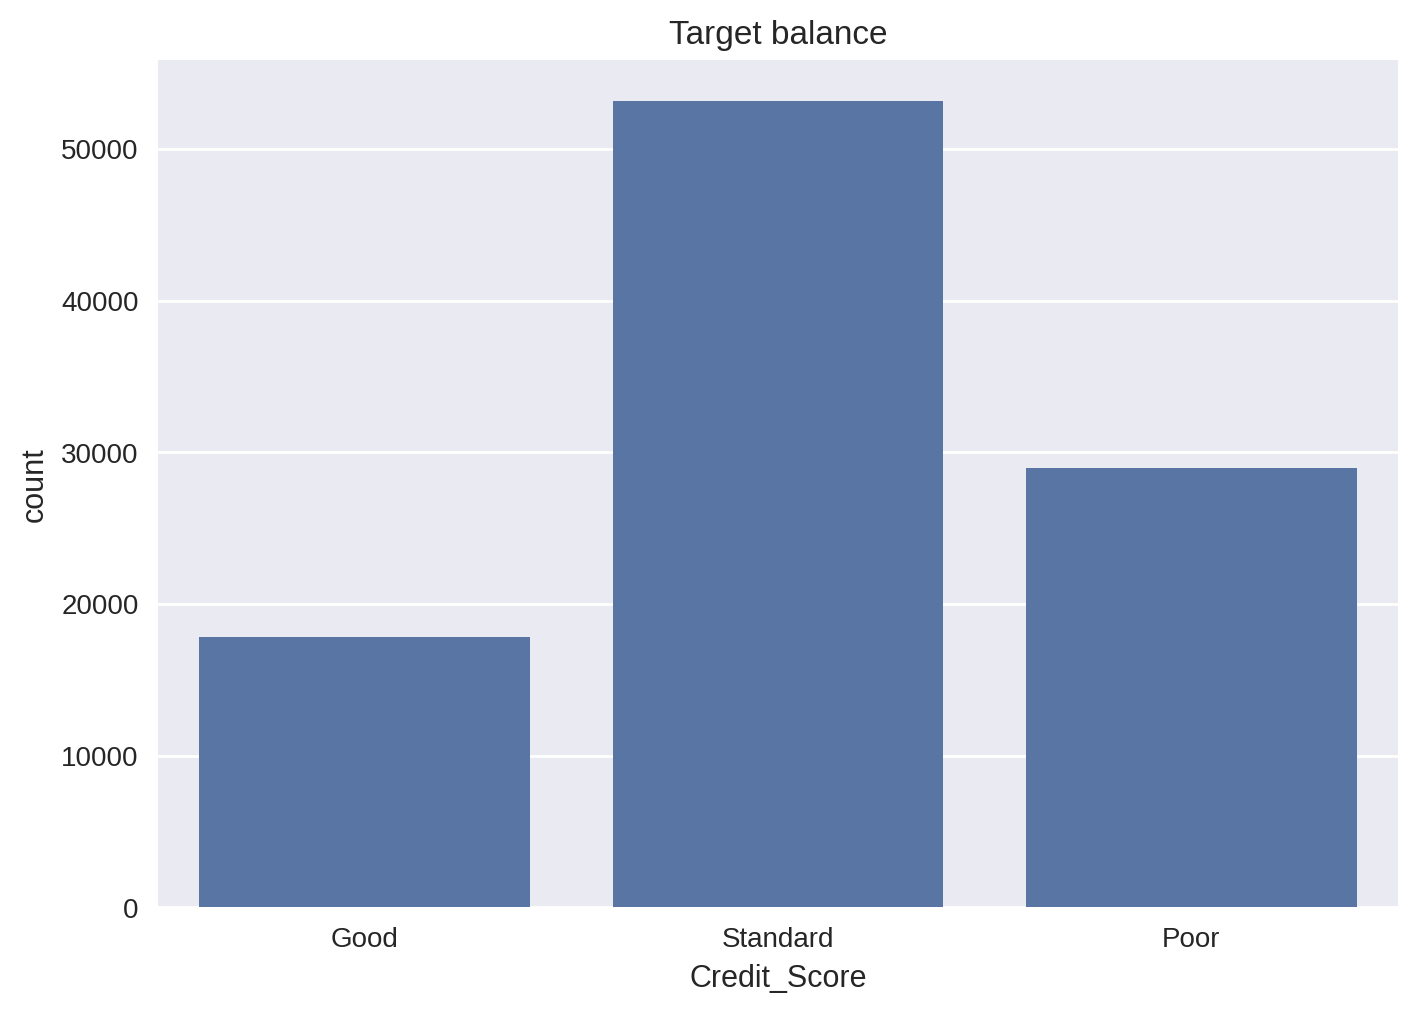

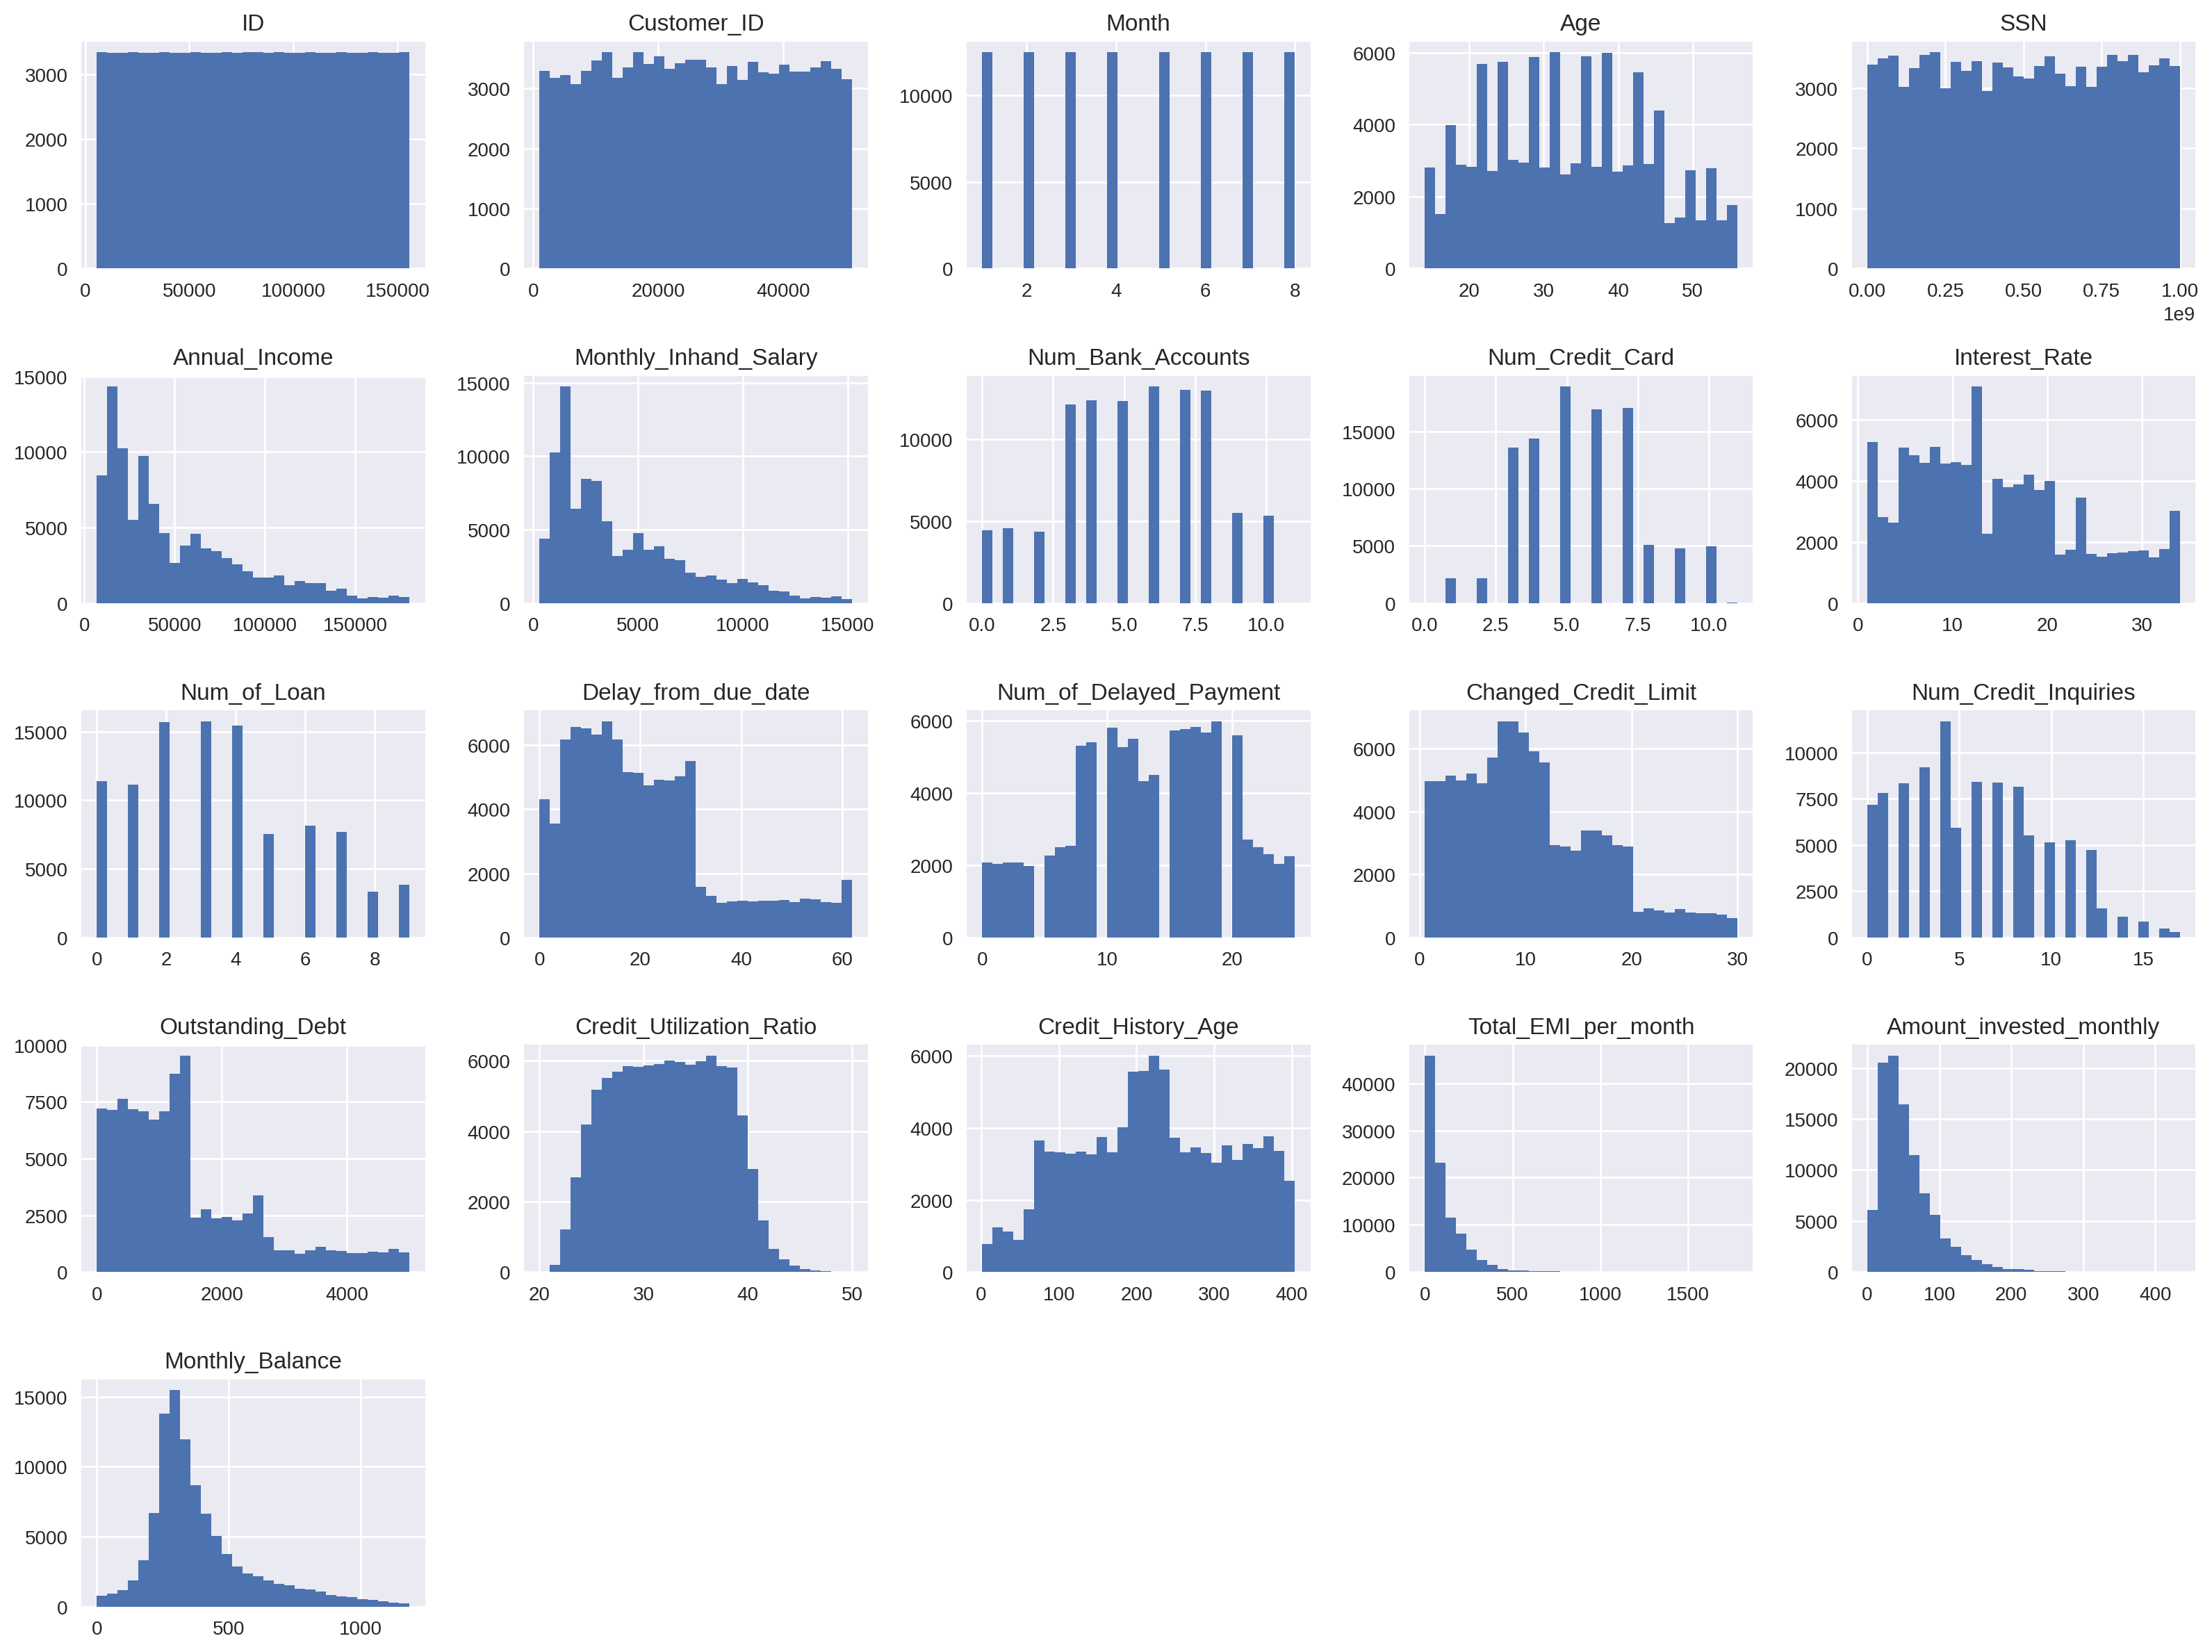

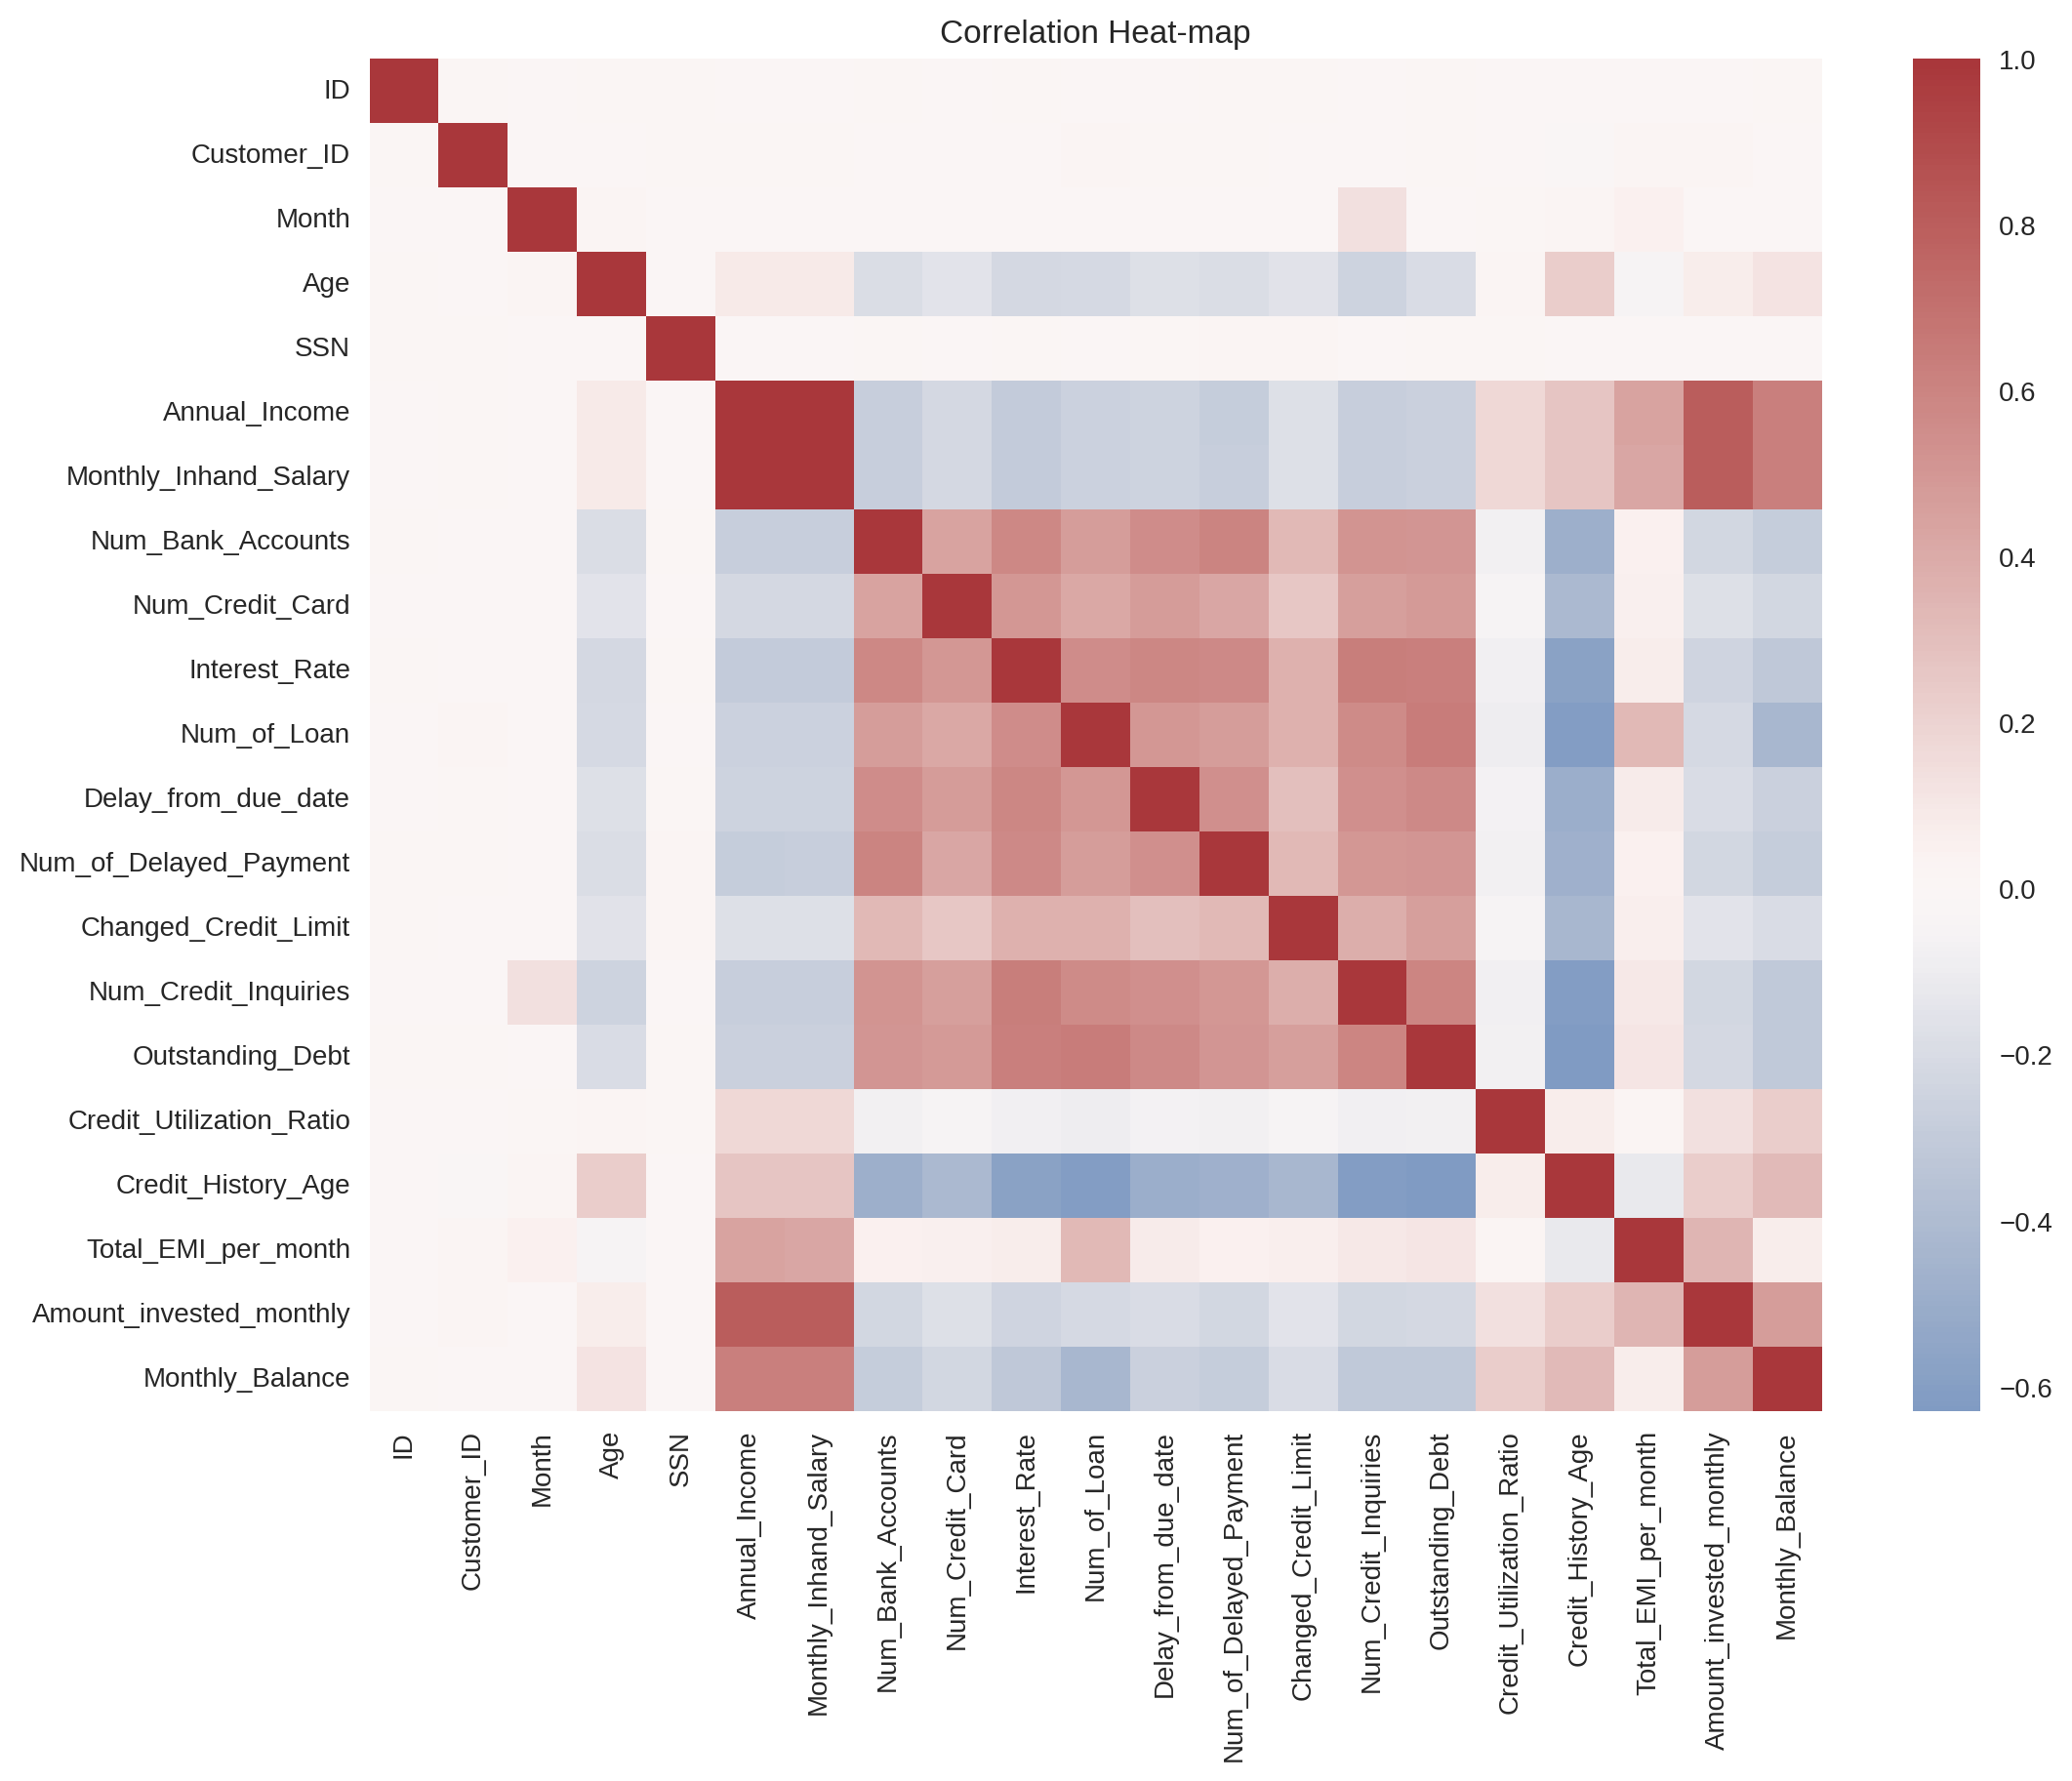

In [ ]:
# Target distribution
sns.countplot(x='Credit_Score', data=df); plt.title('Target balance'); plt.show()

# Numeric distributions
num_cols = df.select_dtypes(include='number').columns
df[num_cols].hist(bins=30, figsize=(16,12))
plt.tight_layout(); plt.show()

# Correlation heat‑map (numeric only)
corr = df[num_cols].corr()
plt.figure(figsize=(12,9))
sns.heatmap(corr, cmap='vlag', center=0); plt.title('Correlation Heat‑map'); plt.show()


# Pre‑processing pipeline

In [ ]:
# Separate target and features
X = df.drop('Credit_Score', axis=1)
y = df['Credit_Score']

# Identify column groups
num_features  = X.select_dtypes(include='number').columns
cat_features  = X.select_dtypes(exclude='number').columns

num_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])

cat_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer([
    ('num', num_pipe, num_features),
    ('cat', cat_pipe, cat_features)
])


# Model benchmarking

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Now y will be 0, 1, 2 instead of 'Good', 'Poor', etc.

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Fit your pipeline
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

# (Optional) Convert predictions back to original labels
y_pred_labels = le.inverse_transform(y_pred)


# Hyper‑parameter tuning

In [ ]:
param_grid = {
    'model__num_leaves'        : [31, 63, 127],
    'model__learning_rate'     : [0.05, 0.1, 0.2],
    'model__n_estimators'      : [200, 400, 600]
}

lgbm = Pipeline([
    ('prep', preprocess),
    ('model', LGBMClassifier(random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(lgbm, param_grid, cv=cv, scoring='f1_macro', n_jobs=-1, verbose=1)
gs.fit(X, y)

print('Best params:', gs.best_params_)
print('Best score :', gs.best_score_)
best_model = gs.best_estimator_


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5166
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 957
[LightGBM] [Info] Start training from score -1.724400
[LightGBM] [Info] Start training from score -1.237943
[LightGBM] [Info] Start training from score -0.631601
Best params: {'model__learning_rate': 0.1, 'model__n_estimators': 600, 'model__num_leaves': 127}
Best score : 0.8303226185065539


# Evaluation visuals

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4644
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 696
[LightGBM] [Info] Start training from score -1.724428
[LightGBM] [Info] Start training from score -1.237917
[LightGBM] [Info] Start training from score -0.631605


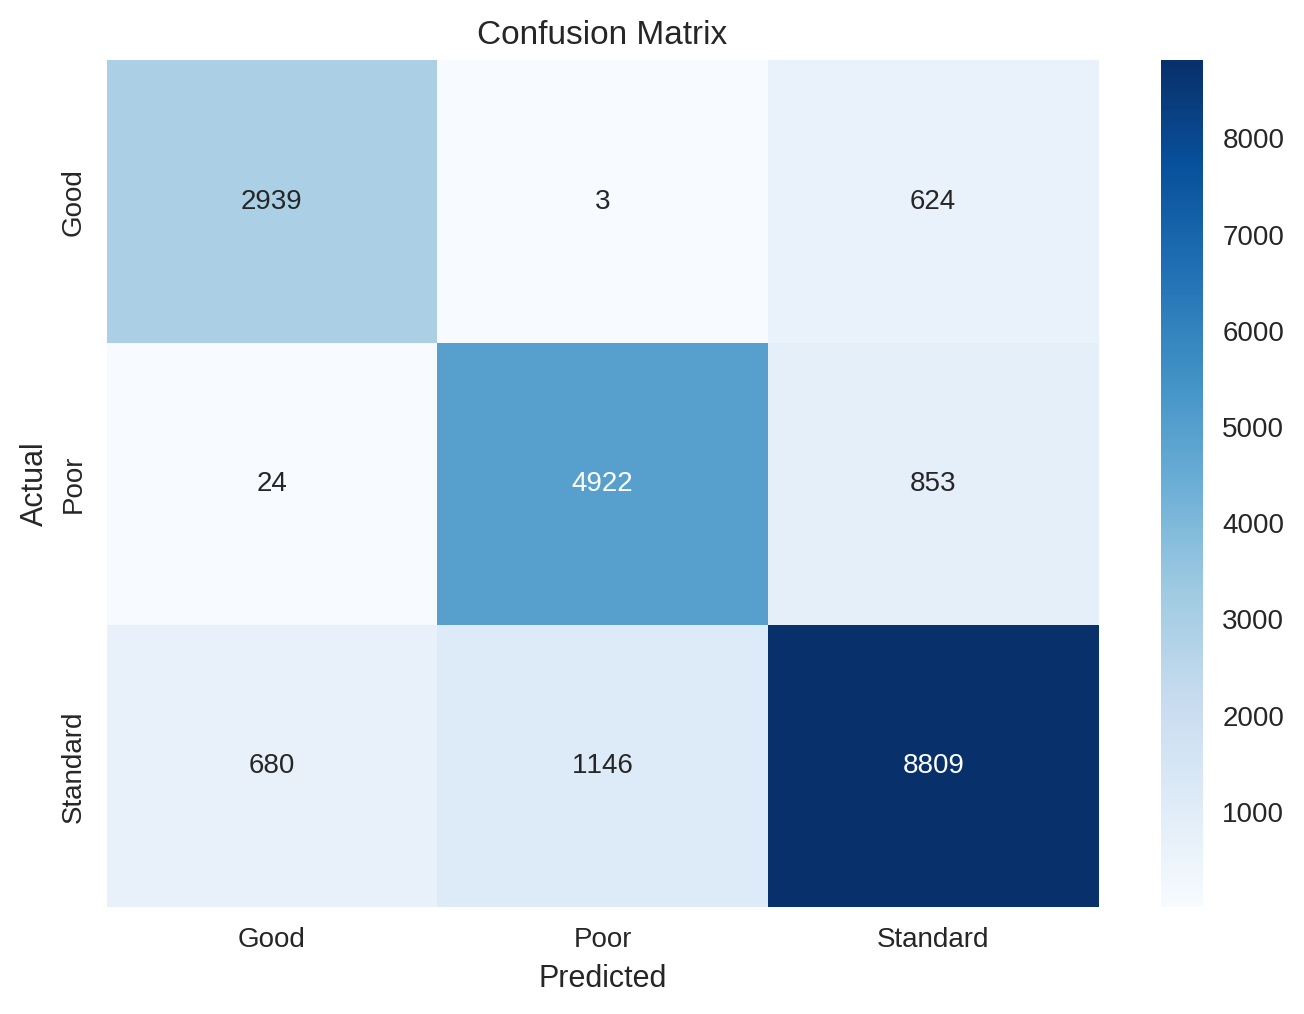

macro ROC‑AUC: 0.9399018369303991


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

best_model.fit(X_train, y_train)
y_pred  = best_model.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model.classes_,
            yticklabels=best_model.classes_)
plt.title('Confusion Matrix'); plt.ylabel('Actual'); plt.xlabel('Predicted'); plt.show()

# ROC‑AUC ovR
y_proba = best_model.predict_proba(X_test)
print('macro ROC‑AUC:', roc_auc_score(y_test, y_proba, multi_class='ovr'))


# Saving artefacts

In [ ]:
joblib.dump(best_model, 'credit_score_pipeline.joblib')


['credit_score_pipeline.joblib']